In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer
import tensorflow_addons as tfa

import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE


## Labels (Photo, Monet)

In [3]:
# Define the labels
LABELS_PHOTO = [
    [2],                     # sky
    [21, 26, 60, 109, 113],  # water
    [4, 9, 17, 29, 66]       # vegetation
]

LABELS_MONET = [
    [1],  # sky
    [2],  # water
    [3]   # vegetation
]

# number of segmentation channels between photos and monet pictures have to match
assert len(LABELS_PHOTO) == len(LABELS_MONET)


In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE =  4
EPOCHS_NUM = 15
IMG_WIDTH = 256
IMG_HEIGHT = 256

NUM_SEG_CHANNELS = len(LABELS_PHOTO)
NUM_RGB_CHANNELS = 3
NUM_CHANNELS = NUM_RGB_CHANNELS + NUM_SEG_CHANNELS


## Photo-Monet dataset

In [5]:
PHOTO_IMAGES_PATH = './monet-photo-data/photo_segmented/photo_jpg/'
PHOTO_SEGMNT_PATH = './monet-photo-data/photo_segmented/photo_segmented_numpy/'

MONET_IMAGES_PATH = './monet-photo-data/monet_segmented/JPEGImages/'
MONET_SEGMNT_PATH = './monet-photo-data/monet_segmented/SegmentationClassNpy/'


In [6]:
# Function to get corresponding segmentation file path for a given image file path
def get_segmentation_path(dir_path, image_file):
    basename = os.path.basename(image_file)
    segmentation_filename = os.path.splitext(basename)[0] + ".npy"
    return os.path.join(dir_path, segmentation_filename)


################# PHOTO #################
photo_image_files = sorted(glob.glob(PHOTO_IMAGES_PATH + '*.jpg'))
photo_segmentation_files = [get_segmentation_path(PHOTO_SEGMNT_PATH, img_file) for img_file in photo_image_files]

# Ensure you have the same number of images and segmentation masks
assert len(photo_image_files) == len(photo_segmentation_files), "Mismatched image and mask counts"
print('Number of Photo images:', len(photo_image_files))


################# MONET #################
monet_image_files = sorted(glob.glob(MONET_IMAGES_PATH + '*.jpg'))
monet_segmentation_files = [get_segmentation_path(MONET_SEGMNT_PATH, img_file) for img_file in monet_image_files]

# Ensure you have the same number of images and segmentation masks
assert len(monet_image_files) == len(monet_segmentation_files), "Mismatched image and mask counts"
print('Number of Monet images:', len(monet_image_files))



Number of Photo images: 7038
Number of Monet images: 300


#### Helper functions for creating and appending binary segmentation masks to RGB

In [7]:
def load_npy_file(path):
    array = np.load(path.numpy().decode('utf-8'))
    return tf.convert_to_tensor(array, dtype=tf.int8)


# Function to create binary masks from segmentation labels
def create_binary_masks(segmentation, labels):
    # Cast segmentation to int32 to match the labels' dtype
    segmentation = tf.cast(segmentation, tf.int32)
    
    # Initialize an empty list to store the masks
    masks = []

    for label_group in labels:
        # Initialize the mask to False for each label group
        mask = tf.zeros_like(segmentation, dtype=tf.bool)

        # Logical OR to combine all labels in the group
        for label in label_group:
            mask = tf.logical_or(mask, tf.equal(segmentation, label))

        # Cast the boolean mask to float and append to the list
        masks.append(tf.cast(mask, tf.float32))

    # Stack along the last dimension to create a multi-channel mask
    binary_masks = tf.stack(masks, axis=-1)

    return binary_masks


# Function to load and preprocess the image and segmentation files
def load_and_preprocess(image_file, segmentation_file, labels):
            
    # Load the image
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1

    # Load the segmentation mask using tf.py_function (to handle numpy operation)
    segmentation = tf.py_function(load_npy_file, [segmentation_file], tf.int8)
    segmentation = tf.cast(segmentation, tf.float32)  # Convert to float without normalizing
    segmentation = tf.reshape(segmentation, [IMG_HEIGHT, IMG_WIDTH])

    # Create binary masks from the segmentation mask
    binary_masks = create_binary_masks(segmentation, labels)

    # Concatenate the image and the binary masks
    combined = tf.concat([image, binary_masks], axis=-1)

    return combined


def wrapper_load_and_preprocess(labels):
    def inner_function(image_file, segmentation_file):
        return load_and_preprocess(image_file, segmentation_file, labels)
    return inner_function



#### Data Augmentation

In [8]:
def data_augment(image):
    num_channels = image.shape[-1]
    
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, num_channels])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, num_channels])
    
    # Random rotation
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image


In [9]:
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.batch(1, drop_remainder=True)

monet_ds = tf.data.Dataset.from_tensor_slices((monet_image_files, monet_segmentation_files))
monet_ds = monet_ds.map(wrapper_load_and_preprocess(LABELS_MONET))
monet_ds = monet_ds.batch(1, drop_remainder=True)


2023-11-09 19:50:06.462881: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 19:50:06.951715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38183 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [10]:
def get_gan_dataset(photo_image_files, photo_segmentation_files, 
                    monet_image_files, monet_segmentation_files, 
                    augment=None, repeat=True, shuffle=True, batch_size=1):

    photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
    photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))

    monet_ds = tf.data.Dataset.from_tensor_slices((monet_image_files, monet_segmentation_files))
    monet_ds = monet_ds.map(wrapper_load_and_preprocess(LABELS_MONET))
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

full_dataset = get_gan_dataset(photo_image_files=photo_image_files,
                               photo_segmentation_files=photo_segmentation_files,
                               monet_image_files=monet_image_files,
                               monet_segmentation_files=monet_segmentation_files,
                               augment=data_augment, 
                               repeat=True, 
                               shuffle=True, 
                               batch_size=BATCH_SIZE)


In [12]:
example_monet_batch, example_photo_batch = next(iter(full_dataset))

assert example_photo_batch.shape == example_monet_batch.shape
print(example_photo_batch.shape)

(4, 256, 256, 6)


2023-11-09 19:51:53.112946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-09 19:51:53.116984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
def visualize_images_and_masks(batch):
    # Number of segmentation channels (assuming they are the last channels)
    num_segmentation_channels = batch.shape[-1] - 3
    
    # Determine the number of rows needed in the subplot
    num_rows = num_segmentation_channels + 1
    
    # Create a subplot with appropriate size
    fig, axes = plt.subplots(num_rows, batch.shape[0], figsize=(15, 2 * num_rows))
    
    for i in range(batch.shape[0]):
        # Extract the RGB image and segmentation masks from the batch
        image = batch[i, ..., :3]
        masks = [batch[i, ..., j] for j in range(3, 3 + num_segmentation_channels)]
        
        # Display the RGB image
        axes[0, i].imshow(tf.keras.preprocessing.image.array_to_img(image))
        axes[0, i].axis('off')
        
        # Display each segmentation mask
        for j, mask in enumerate(masks, 1):
            axes[j, i].imshow(mask, cmap='gray')
            axes[j, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    

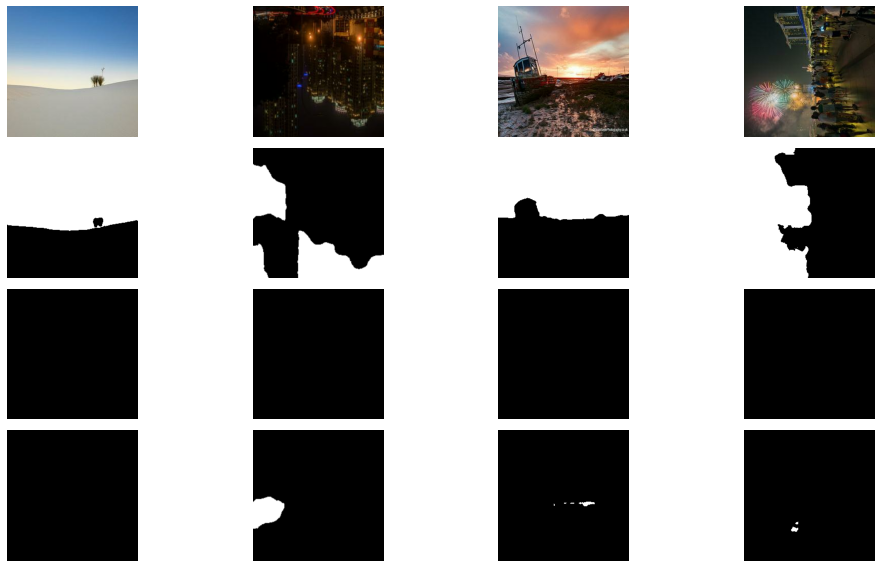

In [14]:
visualize_images_and_masks(example_photo_batch)

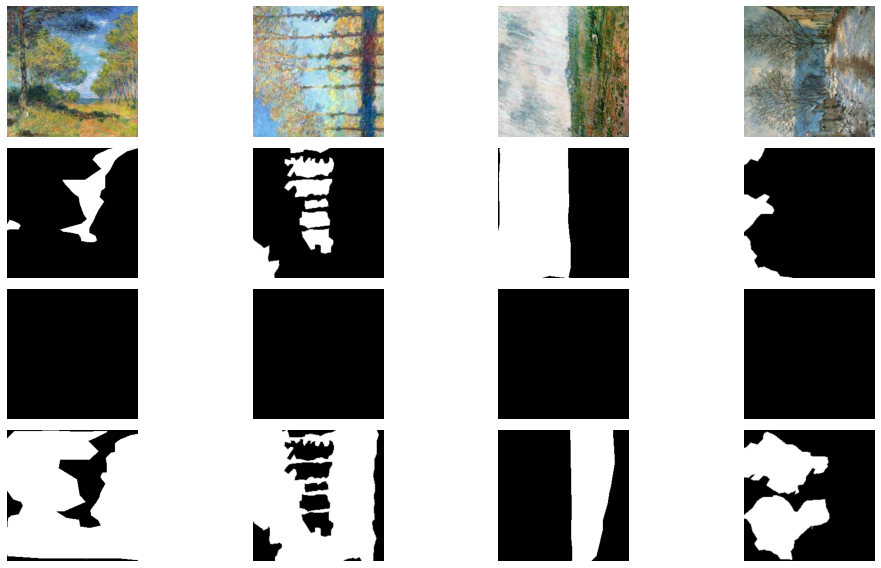

In [15]:
visualize_images_and_masks(example_monet_batch)

## Model

In [16]:
OUTPUT_CHANNELS = NUM_CHANNELS

class SelectiveInstanceNormalization(Layer):
    def __init__(self, **kwargs):
        super(SelectiveInstanceNormalization, self).__init__(**kwargs)
        self.instancenorm = tfa.layers.InstanceNormalization()

    def call(self, inputs):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :3]
        seg = inputs[..., 3:]

        # Apply instance normalization only to the RGB channels
        rgb_normalized = self.instancenorm(rgb)

        # Concatenate the normalized RGB channels with the untouched segmentation channels
        return tf.concat([rgb_normalized, seg], axis=-1)
    

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        # Add the custom normalization layer to the sequential model
        result.add(SelectiveInstanceNormalization())

    result.add(layers.LeakyReLU())

    return result
    


In [17]:
class SelectiveDropout(Layer):
    def __init__(self, rate, **kwargs):
        super(SelectiveDropout, self).__init__(**kwargs)
        self.rate = rate
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :3]
        seg = inputs[..., 3:]

        # Apply dropout only to the RGB channels
        rgb_dropped = self.dropout(rgb, training=training)

        # Concatenate the dropout RGB channels with the untouched segmentation channels
        return tf.concat([rgb_dropped, seg], axis=-1)

    
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Add the custom SelectiveInstanceNormalization layer
    result.add(SelectiveInstanceNormalization())

    if apply_dropout:
        # Add the custom SelectiveDropout layer
        result.add(SelectiveDropout(rate=0.5))

    result.add(layers.ReLU())

    return result


In [18]:
class CustomOutputProcessing(Layer):
    def __init__(self, num_rgb_channels=3, **kwargs):
        super(CustomOutputProcessing, self).__init__(**kwargs)
        self.num_rgb_channels = num_rgb_channels

    def call(self, inputs):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :self.num_rgb_channels]
        seg = inputs[..., self.num_rgb_channels:]

        # Apply tanh to RGB channels for the Monet-style image
        rgb = tf.keras.activations.tanh(rgb)
        
        # Apply sigmoid to segmentation channels for binary masks
        seg = tf.keras.activations.sigmoid(seg)

        # Concatenate the processed RGB and segmentation channels
        return tf.concat([rgb, seg], axis=-1)
    

def Generator():
    inputs = layers.Input(shape=[256, 256, NUM_CHANNELS])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)

    # The last layer before applying custom processing for the output
    last = layers.Conv2DTranspose(NUM_CHANNELS, 4, strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation=None)  # No activation here

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    # Apply the processing using the CustomOutputProcessing layer
    x = CustomOutputProcessing(num_rgb_channels=3)(x)

    return keras.Model(inputs=inputs, outputs=x)


In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Adjust the input shape to take 6-channel images (RGB + segmentation)
    inp = layers.Input(shape=[256, 256, NUM_CHANNELS], name='input_image')

    x = inp

    # The rest of the architecture remains the same, it will automatically
    # adjust to the increased depth due to the change in input shape
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    # The output layer remains the same as it is a scalar output (single channel)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [20]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos


2023-11-09 19:52:29.160030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8303


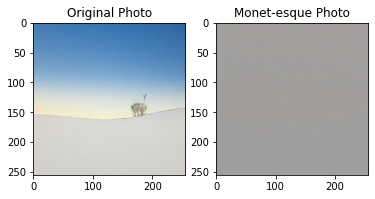

In [21]:
to_monet = monet_generator(example_photo_batch)[0]

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo_batch[0][...,:4] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[...,:4] * 0.5 + 0.5)
plt.show()


In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        lambda_seg=1,  # Weight for segmentation cycle consistency loss
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_seg = lambda_seg
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        seg_loss_fn  # Segmentation cycle consistency loss function
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.seg_loss_fn = seg_loss_fn  # Segmentation cycle consistency loss
        
    def train_step(self, batch_data):
        # Unpack the data
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Segmentation cycle consistency loss
            seg_loss_photo = self.seg_loss_fn(real_photo[..., 3:], cycled_photo[..., 3:])
            seg_loss_monet = self.seg_loss_fn(real_monet[..., 3:], cycled_monet[..., 3:])
            total_seg_loss = seg_loss_photo + seg_loss_monet

            # Total generator loss including segmentation loss
            total_monet_gen_loss += total_seg_loss * self.lambda_seg
            total_photo_gen_loss += total_seg_loss * self.lambda_seg
            
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)


        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "seg_loss": total_seg_loss,
        }



In [23]:
def discriminator_loss(real, generated):
    # Extract RGB channels
    real_rgb = real[..., :3]
    generated_rgb = generated[..., :3]

    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(real_rgb), real_rgb)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.zeros_like(generated_rgb), generated_rgb)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    generated_rgb = generated[..., :3]
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(generated_rgb), generated_rgb)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    real_image_rgb = real_image[..., :3]
    cycled_image_rgb = cycled_image[..., :3]
    loss1 = tf.reduce_mean(tf.abs(real_image_rgb - cycled_image_rgb))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    real_image_rgb = real_image[..., :3]
    same_image_rgb = same_image[..., :3]
    loss = tf.reduce_mean(tf.abs(real_image_rgb - same_image_rgb))
    return LAMBDA * 0.5 * loss

# Minimized Dice loss for segmentation maps
def minimized_dice_loss(real_image, generated_image, smooth=1e-6):
    # Flatten the tensor to compute the Dice coefficient
    y_true_f = tf.reshape(real_image, [-1])
    y_pred_f = tf.reshape(generated_image, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coefficient = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    
    # We subtract the Dice coefficient from 1 to create a loss that needs to be minimized
    return 1 - dice_coefficient


In [24]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [25]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, 
    monet_discriminator, photo_discriminator,
    lambda_cycle=10,  # This weight might need tuning
    lambda_seg=1      # This weight might need tuning
)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    seg_loss_fn=minimized_dice_loss  # Include the segmentation loss function here
)


In [26]:
cycle_gan_model.fit(
    full_dataset,
    epochs=EPOCHS_NUM,
    steps_per_epoch=(max(len(monet_image_files), len(photo_image_files))//BATCH_SIZE)
)


Epoch 1/15


2023-11-09 19:53:43.347766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2000 of 2048
2023-11-09 19:53:43.585815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1759/1759 [==============================] - 236s 108ms/step - monet_gen_loss: 4.3461 - photo_gen_loss: 4.6033 - monet_disc_loss: 0.5097 - photo_disc_loss: 0.4224 - seg_loss: 0.6422
Epoch 2/15
1759/1759 [==============================] - 190s 108ms/step - monet_gen_loss: 2.9270 - photo_gen_loss: 3.0272 - monet_disc_loss: 0.5895 - photo_disc_loss: 0.5709 - seg_loss: 0.2967
Epoch 3/15
1759/1759 [==============================] - 190s 108ms/step - monet_gen_loss: 2.7097 - photo_gen_loss: 2.7775 - monet_disc_loss: 0.5843 - photo_disc_loss: 0.5661 - seg_loss: 0.2388
Epoch 4/15
1759/1759 [==============================] - 190s 108ms/step - monet_gen_loss: 2.6199 - photo_gen_loss: 2.6915 - monet_disc_loss: 0.5815 - photo_disc_loss: 0.5536 - seg_loss: 0.2097
Epoch 5/15
1759/1759 [==============================] - 189s 108ms/step - monet_gen_loss: 2.5305 - photo_gen_loss: 2.5668 - monet_disc_loss: 0.5805 - photo_disc_loss: 0.5615 - seg_loss: 0.1732
Epoch 6/15
1759/1759 [========================

2023-11-09 20:40:51.910295: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-09 20:40:52.034660: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
monet_generator.save_weights('checkpoints_6_channels/monet_generator_checkpoint')

In [28]:
model_tmp = Generator()
model_tmp.load_weights('checkpoints_6_channels/monet_generator_checkpoint')

In [81]:
#example_monet_batch, example_photo_batch = next(iter(full_dataset))
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.shuffle(buffer_size=500)
photo_ds = photo_ds.batch(4, drop_remainder=True)


In [89]:
example_photo = next(iter(photo_ds))
preds = model_tmp.predict(example_photo)


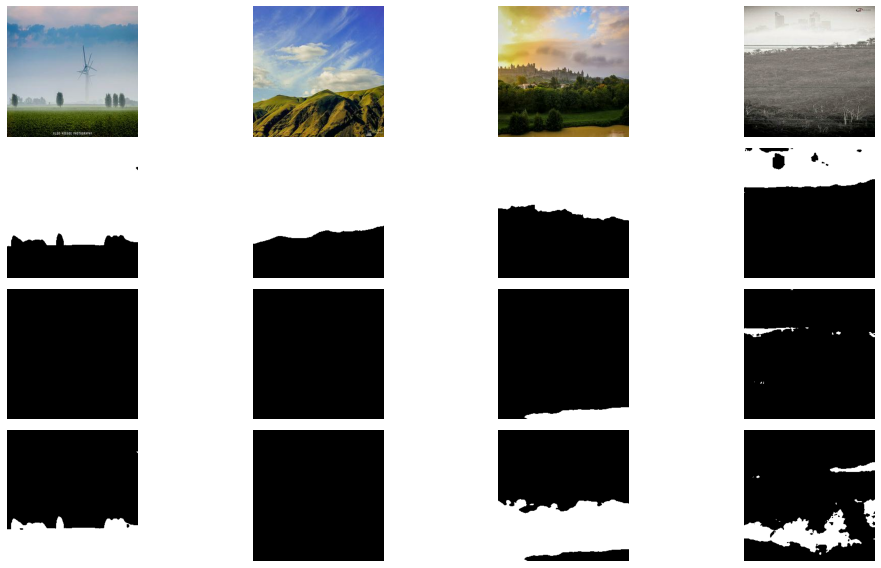

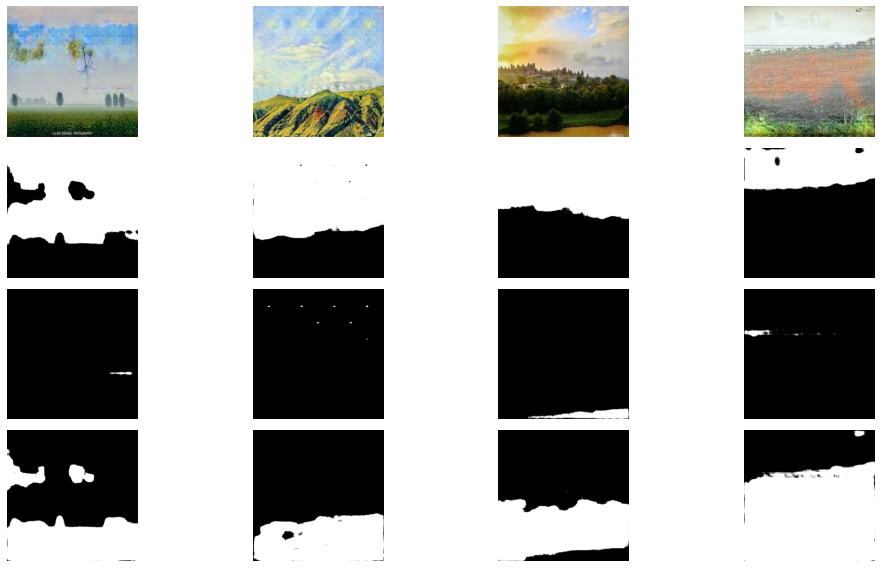

In [90]:

visualize_images_and_masks(example_photo)
print()
visualize_images_and_masks(preds)


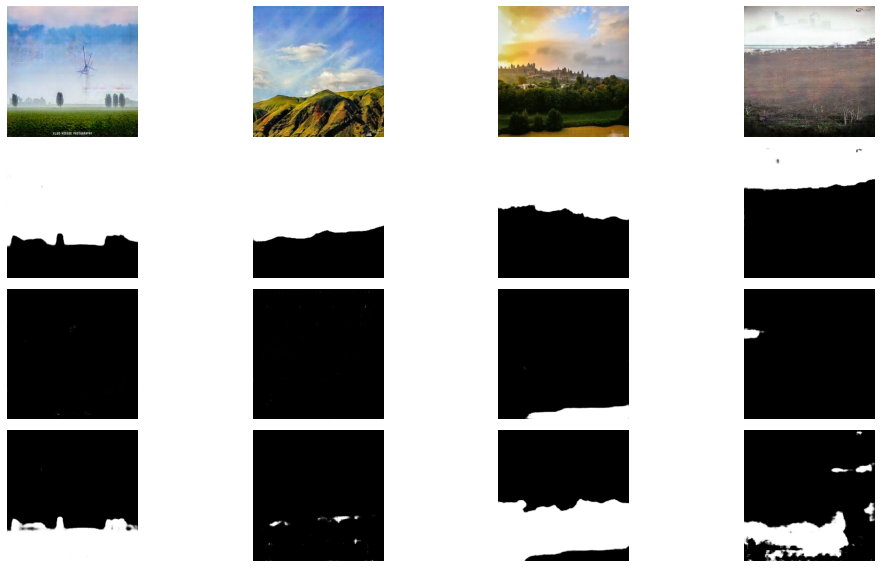

In [91]:
back_photos = photo_generator(preds)

visualize_images_and_masks(back_photos)


In [32]:
import PIL
from tqdm import tqdm

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in tqdm(input_ds, total=len(photo_image_files)):
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction[...,:3])
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1


In [33]:
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.batch(1)

In [34]:
import os
#os.makedirs('output_images') # Create folder to save generated images

predict_and_save(photo_ds, monet_generator, 'output_images/')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7038/7038 [04:50<00:00, 24.23it/s]
